# Introduction 

<p>In this project, two neural network models utilizing the LSTM algorithm both for regression and classification analysis on hourly stock data were developed.</p>
<p>The purpose of this project is to formulate two neural network models that utilize the LSTM (Long Short Term Memory) algorithm one of the variants of Recurrent Neural Network Algorithm for predicting the closing price value of BTC for the next hour and for predicting the probability of rise or fall of a BTC for the next hour respectively.</p>

In [1]:
#imports
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
import torch, os, pickle, gc, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Load Dataset
The stock dataset is loaded into a dataframe similar to a spreadsheet, for visualization and manipulation.

In [2]:
#load training data files
data_dir = '../input/btcinusd'
data_path = os.path.join(data_dir, 'BTC-Hourly.csv')
data = pd.read_csv(data_path, engine='c')
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


It is observed that the dataset is in descending order from latest to earliest data, so below we reverse the order.

In [3]:
#inverse data order
data = data.iloc[::-1]

#drop irrelevant columns
data = data.drop(['unix', 'symbol'], axis=1)
data.head()

,date,open,high,low,close,Volume BTC,Volume USD
33258,2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
33257,2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
33256,2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
33255,2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
33254,2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


# Exploratory Data Analysis

First statistical information like the mean, median, standard deviation, etc pertaining to each quantity column in the dataframe is viewed.

In [4]:
#information on dataset
data.describe()

,open,high,low,close,Volume BTC,Volume USD
count,33259.000000,33259.000000,33259.000000,33259.000000,3.325900e+04,3.325900e+04
mean,20119.546772,20232.957473,19997.069777,20120.684800,1.612380e+06,2.965701e+06
std,18537.219607,18646.950933,18418.320297,18537.695044,3.102328e+06,7.329787e+06
min,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00,0.000000e+00
25%,7022.865000,7055.835000,6970.570000,7022.865000,1.903241e+02,1.682800e+02
50%,9700.040000,9740.270000,9657.000000,9700.320000,6.093271e+05,5.248300e+02
75%,36415.305000,36735.380000,36104.235000,36423.040000,1.929240e+06,3.120014e+06
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 33258 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        33259 non-null  object 
 1   open        33259 non-null  float64
 2   high        33259 non-null  float64
 3   low         33259 non-null  float64
 4   close       33259 non-null  float64
 5   Volume BTC  33259 non-null  float64
 6   Volume USD  33259 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.8+ MB


The *data.info()* returns information on each column of the dataframe.
It is noticed that the 'date' column datatype is 'object' insead of 'datetime64[ns]', so it is assigned the appropriate datatype with the *astype()* method below

In [6]:
data['date'] = data['date'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 33258 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        33259 non-null  datetime64[ns]
 1   open        33259 non-null  float64       
 2   high        33259 non-null  float64       
 3   low         33259 non-null  float64       
 4   close       33259 non-null  float64       
 5   Volume BTC  33259 non-null  float64       
 6   Volume USD  33259 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.8 MB


It is usual for structured data to have missing values in one or more columns.<br>
Below, the availability of missing and infinite values is checked

In [7]:
print(f'NA counts: \n{data.isna().sum()}\n')
print(f'Inf count: \n{data.isin([np.inf, -np.inf]).sum()}')

NA counts: 
date          0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

Inf count: 
date          0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64


It is usual for structured data to have missing values in one or more columns.<br>
Below, the availability of missing and infinite values is checked

<p>No Missing values were found in the dataset.</p>
<p>Alot of available time series data do tend to have missing timestamps.
Missing timestamps in time series data can affect temporality of the data and also training as well, because the features used during training are a sequence of past timestamps used to predict the next timestamp(s).</p>

<p>In this dataset, it's known that the timeframe between consecutive timestamps is one hour, so below the dataset is checked for occurances where the difference between consecutive timestamps is not one hour.</p>

In [8]:
#set date as index
data = data.set_index('date')
(data.index[1:] - data.index[:-1]).value_counts()

0 days 01:00:00    33258
Name: date, dtype: int64

<p>It is seen that the timeframe between all consecutive timestamps is one hour.</p>
<p>Below the trend plot for all available quantities is graphically plotted against their corresponding timestamps for more data visualization.</p>

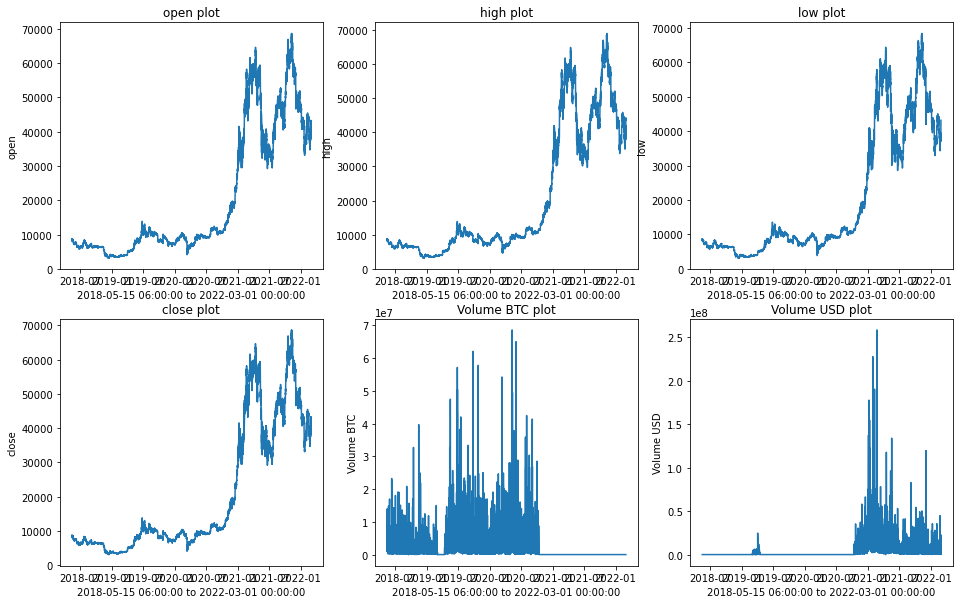

In [9]:
fig, axs = plt.subplots(len(data.columns)//3, 3, figsize = (16, 10))
for idx, i in enumerate(data.columns):
    row, col = 0 if idx<=2 else 1, idx%3
    axs[row, col].plot(data[i])
    axs[row, col].set_xlabel(f'{data.index[0]} to {data.index[-1]}')
    axs[row, col].set_ylabel(i)
    axs[row, col].set_title(f'{i} plot')

Here the correlation between all quantities is visualized.

In [10]:
data.corr()

,open,high,low,close,Volume BTC,Volume USD
open,1.000000,0.999958,0.999936,0.999924,-0.325680,0.479441
high,0.999958,1.000000,0.999905,0.999958,-0.324982,0.482761
low,0.999936,0.999905,1.000000,0.999948,-0.326909,0.474078
close,0.999924,0.999958,0.999948,1.000000,-0.325917,0.479253
Volume BTC,-0.325680,-0.324982,-0.326909,-0.325917,1.000000,-0.210158
Volume USD,0.479441,0.482761,0.474078,0.479253,-0.210158,1.000000


The correlation matrix is better visualized via heatmap.

<AxesSubplot:>

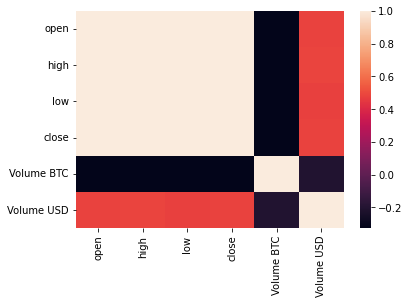

In [11]:

sns.heatmap(data.corr(), xticklabels=data.columns, yticklabels=data.columns)

The distribution curve of the closing price is plotted so as to visualize the variance in the quantity and skeweredness.

Text(0.5, 1.0, 'distribution curve of Closing Price')

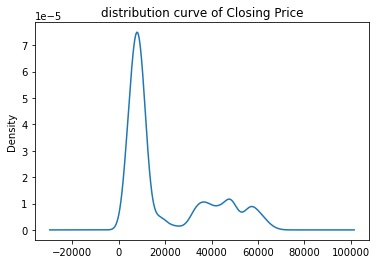

In [12]:
data['close'].plot.kde()
plt.title('distribution curve of Closing Price')

# Feature Engineering

In this phase, the available quantities / features will be used to compute more relevant features that are assumed to affect the convergence of a model trying to fit on this dataset and append to the dataframe of the dataset, some of which are the simple moving average, volumn weighted average price, lower and upper shadow, etc.

In [13]:
old_columns = data.columns
    
def get_features(df):
    #LPC -> Log Price Change
    #SMA -> Simple Moving Average
    #LR -> Log Residual
    #df['VWAP-BTC'] = (df['volume BTC'] * (df['Low'] + df['High'] + df['close']))/df['Volume']
    #df['MOV'] = (df['close'] - df['Open']) / df['VWAP']
    #df['RNG'] = (df['High'] - df['Low']) / df['VWAP']
    #df['CLS'] = (df['close'] - df['VWAP']) / df['VWAP']
    #df['LOGVOL'] = np.log(df['Volume'] + 1)
    df['price mean'] = df[['open', 'high', 'low', 'close']].mean(axis = 1)
    df['upper shadow'] = df['high'] - np.maximum(df['open'], df['close'])
    df['lower shadow'] = np.minimum(df['open'], df['close']) - df['low']
    df['spread'] = df['high'] - df['low']
    df['trade'] = df['close'] - df['open']
    #df['shadow1'] = df['Trade'] / df['volume']
    #df['shadow3'] = df['upper shadow'] / df['volume']
    #df['shadow5'] = df['lower shadow'] / df['volume']
    df['open close LPC'] = np.log(df['close'] / df['open'])
    df['10 period SMA'] = df['close'].rolling(10).mean().fillna(0)
    df['20 period SMA'] = df['close'].rolling(20).mean().fillna(0)
    df['5 period LR'] = pd.Series(np.log(df['close'])).diff(periods=5).fillna(0)
    df['10 period LR'] = pd.Series(np.log(df['close'])).diff(periods=10).fillna(0)
    df['log norm close'] = np.log(df['close'] + 1)/10
    df['buy/sell'] = df['close'].diff(periods=1)
    #drop row where Buy/Sell is NaN to avoid replacing the NaN data with incorrect info
    df = df.copy().loc[df['buy/sell'].notna()]
    df['buy/sell'] = df['buy/sell'].apply(lambda x: 0 if x<=0 else 1)
    return df

#compute features and drop irrelavant column
data = get_features(data)
data.head()

,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,open close LPC,10 period SMA,20 period SMA,5 period LR,10 period LR,log norm close,buy/sell
date,,,,,,,,,,,,,,,,,,
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58,8741.7750,25.01,17.89,44.89,-1.99,-0.000228,0.0,0.0,0.000000,0.0,0.907567,0
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79,8719.5725,11.27,67.96,89.74,-10.51,-0.001203,0.0,0.0,0.000000,0.0,0.907446,0
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62,8723.1400,25.91,6.97,53.05,-20.17,-0.002313,0.0,0.0,0.000000,0.0,0.907215,0
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69,8766.0825,69.10,13.21,169.89,87.58,0.010007,0.0,0.0,0.000000,0.0,0.908215,1
2018-05-15 11:00:00,8795.90,8821.19,8740.54,8760.00,2842987.30,324.11,8779.4075,25.29,19.46,80.65,-35.90,-0.004090,0.0,0.0,0.002172,0.0,0.907807,0


In [14]:
print(f'number of data features: {len(data.columns)}')

number of data features: 18


Statistical information pertaining to all the feauture column in the dataframe is viewed once again.

In [15]:
data.describe()

,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,open close LPC,10 period SMA,20 period SMA,5 period LR,10 period LR,log norm close,buy/sell
count,33258.000000,33258.000000,33258.000000,33258.000000,3.325800e+04,3.325800e+04,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000,33258.000000
mean,20119.889116,20233.301338,19997.409238,20121.026964,1.612281e+06,2.965791e+06,20117.906664,58.448846,68.654350,235.892101,1.137848,0.000051,20114.369897,20107.038782,0.000238,0.000472,0.950143,0.508449
std,18537.393162,18647.125825,18418.493160,18537.868719,3.102322e+06,7.329879e+06,18534.791360,102.611091,141.327072,342.819491,228.238892,0.008155,18536.079297,18534.985472,0.017539,0.024460,0.089032,0.499936
min,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00,0.000000e+00,3142.757500,0.000000,0.000000,0.000000,-4795.170000,-0.180903,0.000000,0.000000,-0.329254,-0.398508,0.805222,0.000000
25%,7022.202500,7055.767500,6970.285000,7022.202500,1.903206e+02,1.682650e+02,7024.244375,7.390000,8.050000,41.340000,-30.667500,-0.002705,7018.582250,7004.729250,-0.005885,-0.008638,0.885697,0.000000
50%,9700.180000,9740.445000,9657.250000,9701.110000,6.092752e+05,5.247750e+02,9700.327500,20.630000,23.000000,87.935000,0.630000,0.000079,9702.623000,9701.495750,0.000277,0.000518,0.918010,1.000000
75%,36416.242500,36736.295000,36105.852500,36423.095000,1.928908e+06,3.120161e+06,36427.364375,63.002500,73.877500,328.327500,34.420000,0.002914,36394.740000,36425.996375,0.006603,0.010121,1.050299,1.000000
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08,68603.682500,4341.390000,5736.760000,8607.430000,3984.430000,0.205483,68044.766000,67657.467500,0.243617,0.282526,1.113646,1.000000


The 'Buy/Sell' column(one of the new features engineered) in the dataset which would be used as the target values for the classification model is visualized to check class imbalance.

number of 0s: 16348 
number of 1s: 16910


Text(0, 0.5, 'timestamps')

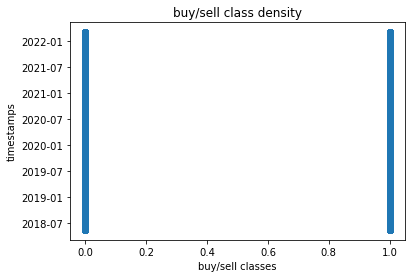

In [16]:
zeroes = len(data['buy/sell'].loc[data['buy/sell']==0])
ones = len(data['buy/sell'].loc[data['buy/sell']==1])

print(f'number of 0s: {zeroes} \nnumber of 1s: {ones}')

plt.scatter(data['buy/sell'], data.index)
plt.title('buy/sell class density')
plt.xlabel('buy/sell classes')
plt.ylabel('timestamps')

The distribution curve of the 'Log Norm Close' column (another newly engineered column) is plotted to visualize variance and check for skeweredness.

Text(0.5, 1.0, 'distribution curve of Log Normalized Closing Price')

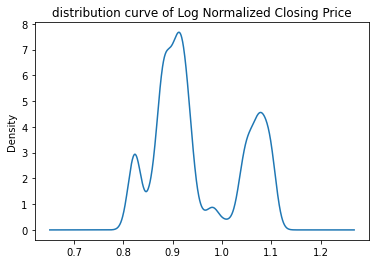

In [17]:
data['log norm close'].plot.kde()
plt.title('distribution curve of Log Normalized Closing Price')

<AxesSubplot:>

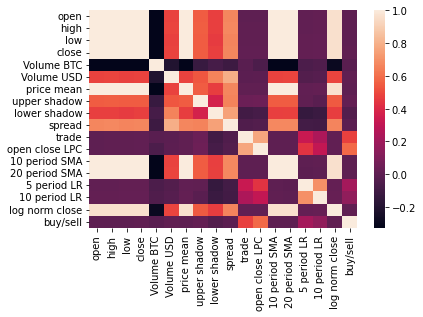

In [18]:
sns.heatmap(data.corr(), xticklabels=data.columns, yticklabels=data.columns)

#  Data Preprocessing

Next, data is split into training and testing with the training data being 96% of the entire dataset and the testing data being 4%

In [19]:
train_size = 0.96
training_data, testing_data = data[0:int(len(data)*train_size)], data[int(len(data)*train_size):]

print(f'number of training samples: {len(training_data)} \nnumber of testing samples: {len(testing_data)}')

number of training samples: 31927 
number of testing samples: 1331


In [20]:
#free up memory
del data
gc.collect()

57

<p>The StockDataset class is a datase pipeline that takes in the dataframe as a parameter alongside the target column, feature and target window sizes. It is passed as an argument to the pytorch dataloader for feeding data into the model in the training loop.</p>
<p>The feature and target window size are used to alter the number of sequences in a single data sample for the features and targets respectively, for example feature size of 20 would imply that the dataset have a shape of: '(N, 20, features)' </p>

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class StockDataset(Dataset):
    
    def __init__(self, df, target_col, feature_window_size=15, target_window_size=1):
        self.feature_window_size = feature_window_size
        self.target_window_size = target_window_size
        self.X, self.y = [], []
        
        for i in tqdm(range(len(df)-self.feature_window_size-self.target_window_size)):
            self.X.append(df[i:i+self.feature_window_size].values)
            self.y.append(df[target_col][i+self.feature_window_size
                                         :i+self.feature_window_size+self.target_window_size].values)
        self.X, self.y = (
            torch.Tensor(self.X).to(device), 
            torch.Tensor(self.y).reshape(-1, self.target_window_size, 1).to(device) if(self.target_window_size>1)else torch.Tensor(self.y).to(device)
        )
        
        self.feature_shape = self.X.shape
        self.target_shape = self.y.shape
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

<h3>Regression Data Preprocessing</h3>

<p>For the Regression data, the MinMax scaler is fitted on the training dataset only and used to scale down the continous values of the training and testing dataset with the exception of 'Log Norm Close' column so that each value falls within the range of 0 to 1.</p>
<P>The MinMax scaler works by subracting the minimum value from each value in a dataset and dividing by the difference between the maximum and the minimum. </P>

In [22]:
#regression data scaler
scaler = MinMaxScaler()
cols_to_scale = training_data.drop(['buy/sell', 'log norm close'], axis=1).columns
scaler = scaler.fit(training_data[cols_to_scale])

scaled_training_data, scaled_testing_data = (
    pd.DataFrame(scaler.transform(training_data[cols_to_scale]), index=training_data.index, columns=cols_to_scale), 
    pd.DataFrame(scaler.transform(testing_data[cols_to_scale]), index=testing_data.index, columns=cols_to_scale)
)

scaled_training_data, scaled_testing_data = (
    pd.concat([scaled_training_data, training_data[['log norm close', 'buy/sell']]], axis=1),
    pd.concat([scaled_testing_data, testing_data[['log norm close', 'buy/sell']]], axis=1)
)

Next the preprocessed training and testing dataframes are used to make two instances of the *StockDataset()* class to create the required dataset objects needed to be passed as argument to the pytorch dataloader.

In [23]:
regression_training_data = StockDataset(scaled_training_data, target_col='close')
regression_testing_data = StockDataset(scaled_testing_data, target_col='close')


100%|██████████| 31911/31911 [00:09<00:00, 3292.83it/s]
/tmp/ipykernel_30828/1854257869.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  torch.Tensor(self.X).to(device),
100%|██████████| 1315/1315 [00:00<00:00, 3290.08it/s]


In [24]:
#check regression data shape
print(f'regression_training_data: \nfeature shape: {regression_training_data.feature_shape} \ntarget shape: {regression_training_data.target_shape}')
print(f'regression_testing_data: \nfeature shape: {regression_testing_data.feature_shape} \ntarget shape: {regression_testing_data.target_shape}')

regression_training_data: 
feature shape: torch.Size([31911, 15, 18]) 
target shape: torch.Size([31911, 1])
regression_testing_data: 
feature shape: torch.Size([1315, 15, 18]) 
target shape: torch.Size([1315, 1])


<h3>Classification Data Preprocessing</h3>

<p>For the Classification data, the standard scaler is fitted on the training dataset only, similar to the regression data and used to scale down the continous values of the training and testing dataset with the exception of 'Log Norm Close' column so that the new values have a mean equal to 0 and unit variance.</p>
<P>The standard scaler works by subracting the mean of a dataset from each value in that dataset and dividing by the standard deviation. </P>

In [25]:
#classification data scaler
scaler = StandardScaler()
cols_to_scale = training_data.drop(['buy/sell', 'log norm close'], axis=1).columns
scaler = scaler.fit(training_data[cols_to_scale])

scaled_training_data, scaled_testing_data = (
    pd.DataFrame(scaler.transform(training_data[cols_to_scale]), index=training_data.index, columns=cols_to_scale), 
    pd.DataFrame(scaler.transform(testing_data[cols_to_scale]), index=testing_data.index, columns=cols_to_scale)
)

scaled_training_data, scaled_testing_data = (
    pd.concat([scaled_training_data, training_data[['log norm close', 'buy/sell']]], axis=1),
    pd.concat([scaled_testing_data, testing_data[['log norm close', 'buy/sell']]], axis=1)
)

Similar to what was done with the regression data, the preprocessed training and testing dataframes were used to make two instances of the *StockDataset()* class to create the required dataset objects needed to be passed as argument to the pytorch dataloader.

In [26]:
classification_training_data = StockDataset(scaled_training_data, target_col='buy/sell', feature_window_size=30)
classification_testing_data = StockDataset(scaled_testing_data, target_col='buy/sell', feature_window_size=30)

100%|██████████| 1300/1300 [00:00<00:00, 3428.83it/s]


In [27]:
#check classification data shape
print(f'classification_training_data: \nfeature shape: {classification_training_data.feature_shape} \ntarget shape: {classification_training_data.target_shape}')
print(f'classification_testing_data: \nfeature shape: {classification_testing_data.feature_shape} \ntarget shape: {classification_testing_data.target_shape}')

classification_training_data: 
feature shape: torch.Size([31896, 30, 18]) 
target shape: torch.Size([31896, 1])
classification_testing_data: 
feature shape: torch.Size([1300, 30, 18]) 
target shape: torch.Size([1300, 1])


# Neural Network CLass

first, we manually set a seed for RND (Random Number Generation) so that the model is somewhat deterministic and reproducable.

In [28]:
torch.manual_seed(0)

<p>Here, the base class of the neural network is defined.<br> It consists of 'n' number of <a href='https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html'>LSTM layers</a> succeeded by a sequence of <a href='https://pytorch.org/docs/stable/generated/torch.nn.Linear.html'>linear/dense layers</a> with <a href='https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html'>ReLU activation</a> function inbetween the dense layers</p>

In [29]:
class LSTMModel(nn.Module):
    
    def __init__(self, num_layers, in_size, hidden_size, 
                 out_size, dropout, seq_len, bidirectional=True):
        
        super(LSTMModel, self).__init__()
        
        self.num_layers = num_layers
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.dropout = dropout
        self.seq_len = seq_len
        self.bidirectional = bidirectional
        self.fc_input = self.hidden_size*2 if (self.bidirectional == True) else self.hidden_size
        
        self.batch_norm = nn.BatchNorm1d(self.seq_len)
        
        self.LSTM = nn.LSTM(
            input_size = self.in_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            dropout = self.dropout,
            bidirectional = self.bidirectional
        )
        
        self.fc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.fc_input, self.fc_input*2),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(self.fc_input*2, self.out_size)
            )
        ]) 
        
    def forward(self, input):
        output = self.batch_norm(input)
        output, (hn, cn) = self.LSTM(output)
        output = output[:, -1, :]
        for fc_layer in self.fc_layers:
            output = fc_layer(output)
        return output

The *RegressionLSTMModel()* and *ClassificationLSTMModel()* classes are a derived class of the *LSTMModel()* base class.<br>
The purpose of defining the derived class is incase the model architecture is not applicable to the classification dataset but to the regression dataset and vice versa, so that they can simply be adjusted without having to edit the base class

In [30]:
class RegressionLSTMModel(LSTMModel):
    
    def __init__(self, num_layers, in_size, hidden_size, 
                 out_size, dropout, seq_len, bidirectional=True):
        
        super(RegressionLSTMModel, self).__init__(num_layers, in_size, hidden_size, 
                 out_size, dropout, seq_len, bidirectional)
    

In [31]:
class ClassificationLSTMModel(LSTMModel):
    
    def __init__(self, num_layers, in_size, hidden_size, 
                 out_size, dropout, seq_len, bidirectional=True):
        
        super(ClassificationLSTMModel, self).__init__(num_layers, in_size, hidden_size, 
                 out_size, dropout, seq_len, bidirectional)
        
        self.dropout_layer = nn.Dropout(self.dropout)
        
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1, self.seq_len//2, kernel_size=3, stride=2, bias=False),
                nn.BatchNorm1d(self.seq_len//2),
                nn.ReLU()
            )
        ])
        
        #get fc_layer input
        rand_data = torch.randn(2, 1, self.fc_input)
        _ = self.conv_layer_pass(rand_data)
        self.fc_input = _.shape[1] * _.shape[2]
                
        self.fc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.fc_input, self.out_size)
            )
        ])
                
    def conv_layer_pass(self, input):
        output = input
        for conv_layer in self.conv_layers:
            output = conv_layer(output)
        output = self.dropout_layer(output)
        return output
        
    def forward(self, input):
        output = self.batch_norm(input)
        output, (hn, cn) = self.LSTM(output)
        #output = output[:, -1, :]
        output = output[:, -1, :].reshape(-1, 1, output.shape[2])
        output = self.conv_layer_pass(output)
        output = output.reshape(-1, output.shape[1]*output.shape[2])
        for fc_layer in self.fc_layers:
            output = fc_layer(output)
        return output
    

Next a function is defined for weight initialization of model linear layers.<br>
The weights of the linear layers of the model are initalized with xavier initialization method and the biases are initialized to zeros

In [32]:
#weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):torch.nn.init.xavier_uniform_(m.weight)

# Model Pipline

The model pipeline is created to queue and automate model processes without having to repeatedly write code for them.
First of all, a base class for a model pipeline is defined alongside some of it's attributes and methods relevant to the entire model training, testing, saving and loading process.

In [33]:
class ModelPipeline():
    
    def __init__(self, model, criterion, optimizer, plot=False):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.plot = plot
        self.training_report = {}
        self.testing_report = {}        
        
    def train_model(self, dataloader):
        pass
    
    def test_model(self, dataloader):
        pass
    
    def save_model(self, filename, file_dir='./Model'):
        if not os.path.isdir(file_dir): os.mkdir(file_dir) 
        state_params = {
            'model_param':self.model.state_dict(),
            'optimizer_param':self.optimizer.state_dict()
        }
        torch.save(state_params, os.path.join(file_dir, filename))
    
    def load_model(self, path):
        state_params = torch.load(path)
        self.model.load_state_dict(state_params['model_param'])
        self.optimizer.load_state_dict(state_params['optimizer_param'])
        
    def plot_comparision(self, actual, pred):
        pass

Similar to the neural network derived classes, The purpose of defining the derived classs *RegressionModelPipeline()* and *ClassificationModelPipeline()* is because they both have difference training processes and give different reports per training cycle

In [34]:
class RegressionModelPipeline(ModelPipeline):
    
    def __init__(self, model, criterion, optimizer, plot=False):
        super(RegressionModelPipeline, self).__init__(model, criterion, optimizer, plot)
        self.training_report = {'training_losses':[]}
        self.testing_report = {'testing_losses':[]}
    
    def train_model(self, dataloader):
        actual_, pred_ = [], []
        self.model.train()
        final_loss = 0
        for idx, batch in tqdm(enumerate(dataloader)):
            self.model.zero_grad()
            X, y = batch[0].to(device), batch[1].to(device)
            y_pred = self.model(X)
            batch_loss = self.criterion(y_pred, y)
            batch_loss.backward()
            self.optimizer.step()
            final_loss += batch_loss.item()
            actual_.append(y.to('cpu').numpy().reshape(-1))
            pred_.append(y_pred.detach().to('cpu').numpy().reshape(-1))
        actual_ = np.hstack(actual_)
        pred_ = np.hstack(pred_)
        self.plot_comparision(actual_, pred_)
        final_loss = final_loss/len(dataloader)
        self.training_report['training_losses'].append(final_loss)
        return final_loss
        
    def test_model(self, dataloader):
        actual_, pred_ = [], []
        self.model.eval()
        final_loss = 0
        with torch.no_grad():
            for idx, batch in tqdm(enumerate(dataloader)):
                X, y = batch[0].to(device), batch[1].to(device)
                y_pred = self.model(X)
                batch_loss = self.criterion(y_pred, y)
                final_loss += batch_loss.item()
                actual_.append(y.to('cpu').numpy().reshape(-1))
                pred_.append(y_pred.to('cpu').numpy().reshape(-1))
            actual_ = np.hstack(actual_)
            pred_ = np.hstack(pred_)
            self.plot_comparision(actual_, pred_)
            final_loss = final_loss/len(dataloader)
            self.testing_report['testing_losses'].append(final_loss)
            return final_loss
        
    def plot_comparision(self, actual, pred):
        if self.plot != True:
            pass
        else:
            plt.plot(actual[-40:-1], label='actual')
            plt.plot(pred[-40:-1], label='label')
            plt.xlabel('timestamps')
            plt.ylabel('prices')
            plt.show()

In [35]:
class ClassificationModelPipeline(ModelPipeline):
    
    def __init__(self, model, criterion, optimizer, plot=False):
        super(ClassificationModelPipeline, self).__init__(model, criterion, optimizer, plot)
        self.training_report = {'training_losses':[], 'training_accuracies':[]}
        self.testing_report = {'testing_losses':[], 'testing_accuracies':[]}
    
    def train_model(self, dataloader):
        actual_, pred_ = [], []
        self.model.train()
        final_loss, final_accuracy = 0, 0
        for idx, batch in tqdm(enumerate(dataloader)):
            self.model.zero_grad()
            X, y = batch[0], batch[1].reshape(-1)
            y_pred = self.model(X)
            batch_loss = self.criterion(y_pred, y.type(torch.LongTensor).to(device))
            batch_loss.backward()
            self.optimizer.step()
            y_pred = torch.argmax(y_pred, dim=1)
            batch_accuracy = accuracy_score(y.to('cpu'), y_pred.to('cpu'))
            final_loss += batch_loss.item()
            final_accuracy += batch_accuracy
            actual_.append(y.to('cpu').numpy())
            pred_.append(y_pred.to('cpu').numpy())
        actual_ = np.hstack(actual_)
        pred_ = np.hstack(pred_)
        self.plot_comparision(actual_, pred_)
        final_loss, final_accuracy = final_loss/len(dataloader), final_accuracy/len(dataloader)
        self.training_report['training_losses'].append(final_loss)
        self.training_report['training_accuracies'].append(final_accuracy)
        return (final_loss, final_accuracy)
        
        
    def test_model(self, dataloader):
        actual_, pred_ = [], []
        self.model.eval()
        final_loss, final_accuracy = 0, 0
        with torch.no_grad():
            for idx, batch in tqdm(enumerate(dataloader)):
                X, y = batch[0], batch[1].reshape(-1)
                y_pred = self.model(X)
                batch_loss = self.criterion(y_pred, y.type(torch.LongTensor).to(device))
                y_pred = torch.argmax(y_pred, dim=1)
                batch_accuracy = accuracy_score(y.to('cpu'), y_pred.to('cpu'))
                final_loss += batch_loss.item()
                final_accuracy += batch_accuracy
                actual_.append(y.to('cpu').numpy())
                pred_.append(y_pred.to('cpu').numpy())
            actual_ = np.hstack(actual_)
            pred_ = np.hstack(pred_)
            self.plot_comparision(actual_, pred_)
            final_loss, final_accuracy = final_loss/len(dataloader), final_accuracy/len(dataloader)
        self.testing_report['testing_losses'].append(final_loss)
        self.testing_report['testing_accuracies'].append(final_accuracy)
        return (final_loss, final_accuracy)
    
    def plot_comparision(self, actual, pred):
        if self.plot != True:
            pass
        else:
            cm = confusion_matrix(actual, pred)
            display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            display_cm.plot()
            plt.show()

Now, during **hyper parameter tuning, model training and testing** the regression aspect is handled before the classification aspect.

# Regression Dataloader Initialization

The dataloaders for regression model corresponding to training and testing are initialized with batch size of 64 and shuffle argument set to *True* in each.
Basically, the pytorch dataloader combines a dataset and a sampler, and provides an iterable over the given dataset.

In [36]:
#dataloaders
training_dataloader = DataLoader(regression_training_data, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(regression_testing_data, batch_size=64, shuffle=True)

# Regression Model Hyperparameter Tuning

<p>In this phase, the <a href='https://optuna.readthedocs.io/en/stable/'>optuna</a> module is used to automate hyper-parameter tuning so that the best hyper-parameters relevant for model convergence is attained, the purpose of this automation is to save time that would usually be spent on manual tuning of hyper-parameters.</p>
<p>Below, the hyper parameters that do not need to be tuned are defined as global variables alongside the cost / criterion function which is a combination of mean square error and mean absolute error.<br>
The tuning function is then defined.<br>
It takes the trial and the globally defined hyper parameters as positional arguments and returns a metric value corresponding to the best testing loss value.<br>
<a href='https://optuna.readthedocs.io/en/v1.0.0/tutorial/index.html'>Refer to this page to get started with optuna.</a></p>
<p>Usually, after defining the tuning function, a study is instantiated and optimized with a sampler and pruning algorithm, but because the tuning function requires positional arguments, it was wrapped around the lambda keyword, which takes only the trial as argument and returns the tuning function that takes that same trial and the globally defined hyper-parameters as positional arguments and assign all that to a variable called 'objective'.</p>
<p>Afterwards, a study is instantiated with an optimization direction (in this case 'minimization'), a study name, a <a href='https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler'>Tree Parzen Estimator Sampler</a> and <a href='https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html'>median pruning algorithm</a>, which is followed by the study optimization method that takes the objective function and number of trials as positional arguments.</p>

In [37]:
input_size = regression_training_data.feature_shape[-1]
feature_seq_len = regression_training_data.feature_window_size
output_size = 1
criterion = lambda x, y : nn.MSELoss()(x, y)+nn.L1Loss()(x, y)
EPOCHS = 50

def tuning_function(trial, input_size, feature_seq_len, output_size, criterion, epochs):
    #regresssion model hyper-parameters
    num_layers = trial.suggest_int('num_layers', 2, 10)
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    dropout = trial.suggest_float('dropout', 0, 0.5)
    learning_rate = trial.suggest_float('learning_rate',1e-3, 1e-2)
    weight_decay_rate = trial.suggest_float('weight_decay_rate', 0.0, 9e-5)
    
    #regresssion model
    model = RegressionLSTMModel(
        num_layers=num_layers, in_size=input_size, hidden_size=hidden_size,
        out_size=output_size, dropout=dropout, seq_len=feature_seq_len
    ).to(device)

    #xavier weight initializer
    model.apply(init_weights)

    #optimizer
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop', 'SGD'])
    optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(), lr = learning_rate, 
        weight_decay=weight_decay_rate
    )
    
    #model pipeline
    pipeline = RegressionModelPipeline(
        model, criterion, optimizer
    )
    
    #training process
    best_loss = np.inf
    for epoch_ in range(epochs):
        training_loss = pipeline.train_model(training_dataloader)
        testing_loss = pipeline.test_model(testing_dataloader)
        if testing_loss < best_loss:
            best_loss = testing_loss            
        trial.report(best_loss, epoch_)
        if trial.should_prune(): raise optuna.exceptions.TrialPruned()
    
    return best_loss

objective = lambda trial:tuning_function(
    trial, input_size=input_size, feature_seq_len=feature_seq_len,
    output_size=output_size, criterion=criterion, epochs=EPOCHS)

study_name = 'regresssion_model_tuning'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.create_study(
    direction='minimize',
    study_name=study_name, 
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=30)

[I 2022-05-10 11:45:23,921] A new study created in memory with name: regresssion_model_tuning
10it [00:12, 47.15it/s]

After tuning process, the parameters that yielded the best result is selected and assigned to a variable.

In [ ]:
best_params = study.best_params
best_params

# Regression Model Initialization, Training and Testing

The best parameters are used to instantiate a regression model and an optimizer which are passed as arguments to a new instance of the *RegressionModelPipeline()* class

In [ ]:
#regression model
model = RegressionLSTMModel(
    num_layers=best_params['num_layers'], 
    in_size=input_size, hidden_size=best_params['hidden_size'],
    out_size=output_size, dropout=best_params['dropout'], seq_len=feature_seq_len
).to(device)

#optimizer
optimizer = getattr(torch.optim, best_params['optimizer_name'])(
    model.parameters(), lr=best_params['learning_rate'],
    weight_decay = best_params['weight_decay_rate'])

#pipeline
pipeline = RegressionModelPipeline(
    model, criterion, optimizer, plot=True
)

<p>The regression model is trained with those hyper-parameters for 150 epochs and for each cycle testing is done, after which training and testing losses are printed out.</p>
<p>The model is saved at the last epoch with the least testing loss.</p>

In [ ]:
EPOCHS = 150
best_loss = np.inf
model_filename = 'stockdata_regression_model.pth.tar'

for epoch_ in range(EPOCHS):
    print('training: ')
    training_loss = pipeline.train_model(training_dataloader)
    print('testing: ')
    testing_loss = pipeline.test_model(testing_dataloader)
    print(f'Epoch: {epoch_}')
    print(f'training loss: {training_loss}')
    print(f'testing loss: {testing_loss}\n\n')
    if testing_loss < best_loss:
        best_loss = testing_loss
        pipeline.save_model(model_filename)
        print(f'model saved at epoch {epoch_}')
print(f'best testing loss after {EPOCHS} epochs is: {best_loss}')

# Classification Dataloader Initialization

The dataloaders for classification model training and testing are initialized with batch size of 64 and shuffle argument set to *True* in each.

In [ ]:
#dataloaders
training_dataloader = DataLoader(classification_training_data, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(classification_testing_data, batch_size=64, shuffle=True)

# Classification Model Hyperparameter Tuning

The hyper-parameter tuning for the classification model is fairly the same as that of the regression model, with the only differences being the criterion function which is <a href='https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html'>cross entropy</a> loss and the direction of the optimization which is 'maximization' because the objective is to maximize the best accuracy value returned after model testing.

In [ ]:
input_size = classification_training_data.feature_shape[-1]
feature_seq_len = classification_training_data.feature_window_size
output_size = 2
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

def tuning_function(trial, input_size, feature_seq_len, output_size, criterion, epochs):
    # classification model hyper-parameters
    num_layers = trial.suggest_int('num_layers', 2, 20)
    hidden_size = trial.suggest_int('hidden_size', 10, 256)
    dropout = trial.suggest_float('dropout', 0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate',1e-4, 1e-2)
    weight_decay_rate = trial.suggest_loguniform('weight_decay_rate', 1e-8, 9e-6)
    
    # classification model
    model = ClassificationLSTMModel(
        num_layers=num_layers, in_size=input_size, hidden_size=hidden_size,
        out_size=output_size, dropout=dropout, seq_len=feature_seq_len
    ).to(device)

    # xavier weight initializer
    model.apply(init_weights)

    # optimizer
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop', 'SGD'])
    optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(), lr = learning_rate, 
        weight_decay=weight_decay_rate
    )
    
    # model pipeline
    pipeline = ClassificationModelPipeline(
        model, criterion, optimizer
    )
    
    # training process
    best_accuracy = -np.inf
    for epoch_ in range(epochs):
        _, training_accuracy = pipeline.train_model(training_dataloader)
        _, testing_accuracy = pipeline.test_model(testing_dataloader)
        if testing_accuracy > best_accuracy:
            best_accuracy = testing_accuracy          
        trial.report(best_accuracy, epoch_)
        if trial.should_prune(): raise optuna.exceptions.TrialPruned()
    
    return best_accuracy


objective = lambda trial:tuning_function(
    trial, input_size=input_size, feature_seq_len=feature_seq_len,
    output_size=output_size, criterion=criterion, epochs=EPOCHS)

study_name = 'classification_model_tuning'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.create_study(
    direction='maximize',
    study_name=study_name, 
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=100)

After tuning process, the parameters that yielded the best result is selected and assigned to a variable.

In [ ]:
best_params = study.best_params
best_params

# Classification Model Initialization, Training and Testing

Similar to the regression model, the best parameters are used to instantiate a classification model and an optimizer which are passed as arguments to a new instance of the *ClassificationModelPipeline()* class

In [ ]:
#classification model
model = ClassificationLSTMModel(
    num_layers=best_params['num_layers'], 
    in_size=input_size, hidden_size=best_params['hidden_size'],
    out_size=output_size, dropout=best_params['dropout'], seq_len=feature_seq_len
).to(device)

#optimizer
optimizer = getattr(torch.optim, best_params['optimizer_name'])(
    model.parameters(), lr=best_params['learning_rate'],
    weight_decay = best_params['weight_decay_rate'])

#pipeline
pipeline = ClassificationModelPipeline(
    model, criterion, optimizer, plot=True
)

<p>The classification model is trained with those hyper-parameters for 150 epochs and for each cycle testing is done, after which training and testing accuracies and losses are printed out.</p>
<p>The model is saved at the last epoch with the best testing accuracy.</p>

In [ ]:
EPOCHS = 150
best_accuracy = -np.inf
model_filename = 'stockdata_classification_model.pth.tar'

for epoch_ in range(EPOCHS):
    print('training: ')
    training_loss, training_accuracy = pipeline.train_model(training_dataloader)
    print('testing: ')
    testing_loss, testing_accuracy = pipeline.test_model(testing_dataloader)
    print(f'Epoch: {epoch_}')
    print(f'training loss: {training_loss} \ntraining accuracy: {training_accuracy}')
    print(f'testing loss: {testing_loss} \ntesting accuracy: {testing_accuracy}')
    if testing_accuracy > best_accuracy:
        best_accuracy = testing_accuracy
        pipeline.save_model(model_filename)
        print(f'\nmodel saved at epoch {epoch_}')
        
print(f'best testing accuracy after {EPOCHS} epochs is: {best_accuracy}')